In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [3]:
tickers = ['BIGC', 'SRAC', 'MAXR', 'FSLY', 'BPF-UN.TO',
          'PACB', 'BYND', 'BNGO', 'PLUG', 'SPCE']

In [8]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices = prices.dropna()
prices

[*********************100%***********************]  10 of 10 completed


,BIGC,BNGO,BPF-UN.TO,BYND,FSLY,MAXR,PACB,PLUG,SPCE,SRAC
Date,,,,,,,,,,
2020-08-05,72.269997,0.75,6.780229,132.690002,108.919998,20.715347,3.920000,9.330000,20.150000,9.97
2020-08-06,93.510002,0.80,6.799464,132.580002,89.639999,25.002317,4.080000,10.730000,19.340000,9.97
2020-08-07,79.000000,0.86,6.751377,131.509995,79.330002,24.722515,4.730000,11.280000,18.250000,9.97
2020-08-10,76.720001,0.84,6.886020,127.430000,78.180000,24.432720,4.710000,12.040000,19.230000,9.97
2020-08-11,72.570000,0.80,6.943724,125.500000,74.959999,24.832436,4.470000,11.310000,18.280001,10.02
...,...,...,...,...,...,...,...,...,...,...
2021-01-21,71.320000,8.27,10.770000,134.610001,104.129997,51.080002,36.310001,63.689999,33.270000,26.26
2021-01-22,71.250000,9.80,10.640000,140.699997,103.279999,50.220001,37.419998,66.870003,34.279999,24.85
2021-01-25,80.010002,12.58,10.600000,158.729996,105.209999,50.150002,35.950001,65.720001,36.000000,23.68


In [7]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.968958
1993-02-01    26.153660
1993-02-02    26.209057
1993-02-03    26.486113
1993-02-04    26.596937
Name: Adj Close, dtype: float64

In [9]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'BIGC': 6102603264,
 'SRAC': 444360768,
 'MAXR': 2656749568,
 'FSLY': 12369230848,
 'BPF-UN.TO': 225545312,
 'PACB': 5815146496,
 'BYND': 12034907136,
 'BNGO': 3001003264,
 'PLUG': 30151651328,
 'SPCE': 10861751296}

## Constructing the prior
Black and Litterman (1991) provide the insight that a natural choice for prior: the market’s estimate of the return, which is embedded into the market cap of the asset.

Note

* A significant body of research shows that mean historical returns are a completely uninformative prior.Technically no prior estimate is needed for the Black-Litterman model. This is particularly useful if views (and confidences) were generated by some proprietary model, in which case BL is essentially a clever way of mixing views.

In [11]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [12]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.6153248560812887

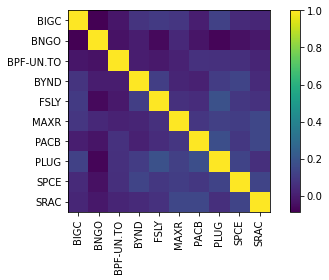

In [13]:
plotting.plot_covariance(S, plot_correlation=True);

In [14]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

BIGC         0.587003
BNGO         0.220198
BPF-UN.TO    0.110354
BYND         0.548225
FSLY         0.751493
MAXR         0.363306
PACB         0.481626
PLUG         1.536794
SPCE         0.651732
SRAC         0.224363
dtype: float64

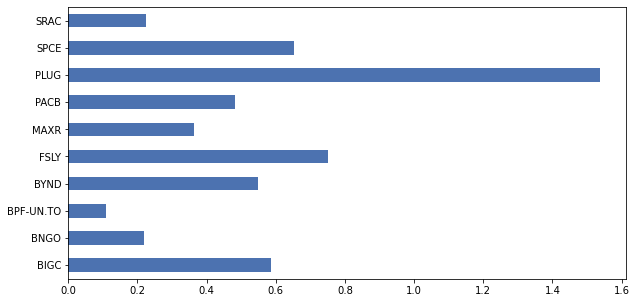

In [15]:
market_prior.plot.barh(figsize=(10,5));

## Views
In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing absolute views (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.b

In [21]:
# You don't have to provide views on all the assets
viewdict = {
    'BIGC': 0.40,
    'SRAC': 0.40,
    'MAXR': 0.85,
    'FSLY': 0.35,
    'BPF-UN.TO': 0.20,
    'PACB': 0.55,  # I think Coca-Cola will go down 5%
    'BYND': 0.35,
    'BNGO': 0.50,
    'PLUG': 0.40,  # but low confidence, which will be reflected later
    'SPCE': 0.800
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

## View confidences
In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [22]:
confidences = [
    0.6,
    0.4,
    0.7,  # confident in MAXAR
    0.6,
    0.5,
    0.5, 
    0.7, 
    0.2, # believe BNGO will do poorly -- not included in ARKG
    0.5,
    0.4
]

In [23]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

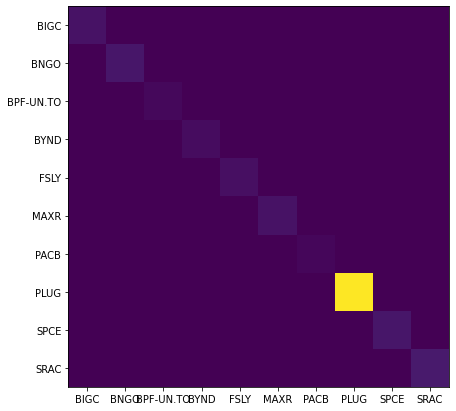

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [27]:
omega = np.diag(bl.omega)
omega

array([0.05357054, 0.06979607, 0.02233881, 0.03619991, 0.04706031,
       0.05421832, 0.01791977, 1.13586833, 0.06725605, 0.08058621])

## Posterior estimates
Given the inputs, we can compute a posterior estimate of returns

In [29]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=bl.omega)

In [31]:
ret_bl = bl.bl_returns()
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BIGC,0.587003,0.441304,0.40
BNGO,0.220198,0.368854,0.50
BPF-UN.TO,0.110354,0.140189,0.20
BYND,0.548225,0.389248,0.35
FSLY,0.751493,0.473828,0.35
MAXR,0.363306,0.682402,0.85
PACB,0.481626,0.483393,0.55
PLUG,1.536794,0.972634,0.40
SPCE,0.651732,0.677257,0.80
SRAC,0.224363,0.299798,0.40


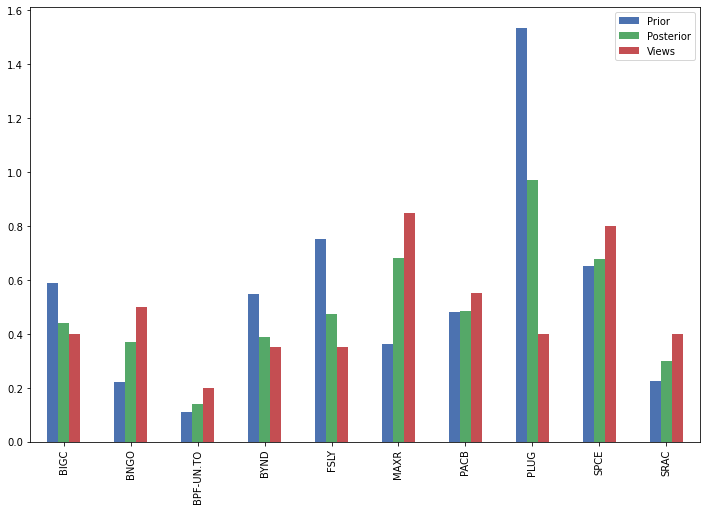

In [32]:
rets_df.plot.bar(figsize=(12,8));


Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

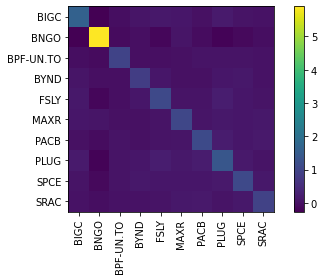

In [34]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation
Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimisers discussed in previous recipes.

In [35]:
from pypfopt import EfficientFrontier, objective_functions

In [36]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/opt/conda/lib/python3.8/site-packages/pypfopt/efficient_frontier.py:195: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('BIGC', 0.07317),
             ('BNGO', 0.04462),
             ('BPF-UN.TO', 0.02444),
             ('BYND', 0.09076),
             ('FSLY', 0.09224),
             ('MAXR', 0.16376),
             ('PACB', 0.09822),
             ('PLUG', 0.20959),
             ('SPCE', 0.15547),
             ('SRAC', 0.04773)])

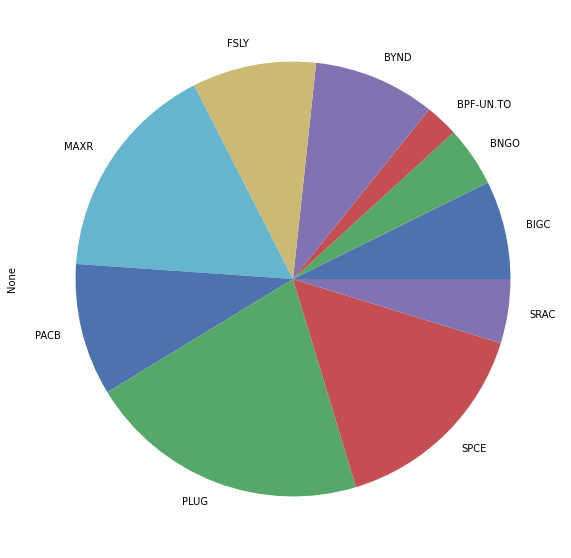

In [37]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [39]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=10000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $0.41


{'BIGC': 8,
 'BNGO': 41,
 'BPF-UN.TO': 23,
 'BYND': 5,
 'FSLY': 8,
 'MAXR': 38,
 'PACB': 31,
 'PLUG': 33,
 'SPCE': 33,
 'SRAC': 24}